In [1]:
DATASET = "celeba"
ROOT_DIR = "/mnt/external/pytorch_datasets/"

Z_DIM = 100

LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

BATCH_SIZE = 128
GAN_EPOCHS = 10
ENC_EPOCHS = 10

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

from cpe import CPE, CallbackList, SaveLossCallback, Callback

if DATASET == "mnist":
    from torchvision.datasets import MNIST
    from torchvision.transforms import Compose, ToTensor, Normalize
    from cpe.mnist import Generator, Discriminator, Encoder
elif DATASET == "celeba":
    from torchvision.datasets import CelebA
    from torchvision.transforms import Compose, Resize, ToTensor, Normalize
    from cpe.celeba import Generator, Discriminator, Encoder
else:
    raise ValueError(f"Dataset {DATASET} is not available.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
if DATASET == "mnist":
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = MNIST(ROOT_DIR, train=False, transform=transform, download=True)
elif DATASET == "celeba":
    transform = Compose([Resize((64, 64)), ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = CelebA(ROOT_DIR, split="all", transform=transform, download=True)
else:
    raise ValueError(f"Dataset {DATASET} is not available.")

dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

Files already downloaded and verified


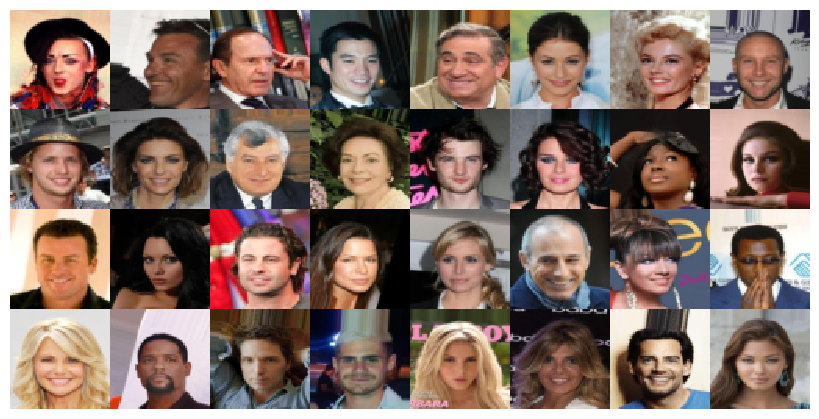

In [4]:
if DATASET == "mnist":
    imagify = lambda img: img.detach().cpu().numpy().squeeze() / 2 + 0.5
elif DATASET == "celeba":
    imagify = lambda img: img.detach().cpu().numpy().swapaxes(1, 2).swapaxes(2, 3) / 2 + 0.5
else:
    raise ValueError(f"Dataset {DATASET} is not available.")

sample = imagify(next(iter(dataloader))[0])
plt.figure(figsize=(8, 4))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.axis("off")
    plt.imshow(sample[i], cmap="gray", interpolation="nearest")
plt.tight_layout(pad=0)
plt.show()

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



In [6]:
generator = Generator(Z_DIM)
g_optim = Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
generator.apply(weights_init)

discriminator = Discriminator()
d_optim = Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
discriminator.apply(weights_init)

encoder = Encoder(Z_DIM)
e_optim = Adam(encoder.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
encoder.apply(weights_init)

cpe = CPE(generator, discriminator, encoder, Z_DIM, device=device)

print(generator)
print(discriminator)
print(encoder)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2

In [7]:
class PlotCallback(Callback):
    def __init__(self, z: torch.Tensor):
        self.z = z
        self.maxbatch = 0

    def plot_generated(self, model):
        plt.figure(figsize=(16, 1))
        with torch.no_grad():
            generated = imagify(model.generator(self.z.to(device)))
        for i in range(16):
            plt.subplot(1, 16, i + 1)
            plt.axis("off")
            plt.imshow(generated[i], cmap="gray", interpolation="nearest")
        plt.tight_layout(pad=0)
        plt.show()

    def on_epoch_end(self, epoch, model, epochs_iterator):
        self.plot_generated(model)


class UpdateCallback(Callback):
    def __init__(self, labels):
        self.labels = labels

    def on_batch_end(self, epoch, batch, model, losses: tuple, epochs_iterator, batches_iterator):
        batches_iterator.set_description(
            " | ".join("%s %4f" % (label, v) for label, v in zip(self.labels, losses))
        )


gan_recorder = SaveLossCallback(3, 10)
gan_updater = UpdateCallback(["Real", "Fake", "Generator"])
enc_recorder = SaveLossCallback(2, 10)
enc_updater = UpdateCallback(["E2E", "I2I"])

  0%|          | 0/10 [00:00<?, ?e/s]

  0%|          | 0/1583 [00:00<?, ?b/s]

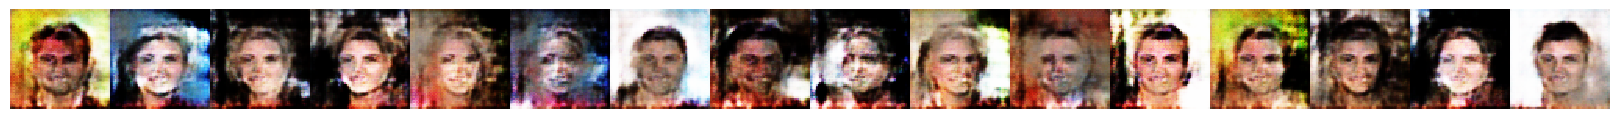

KeyboardInterrupt: 

In [8]:
fixed_z = cpe.generate_z(16)
cpe.train_gan(
    GAN_EPOCHS,
    g_optim,
    d_optim,
    dataloader,
    callback=CallbackList(PlotCallback(fixed_z), gan_updater, gan_recorder),
    use_tqdm=2,
)
torch.save(generator.state_dict(), f"{DATASET}_generator.pth")
torch.save(discriminator.state_dict(), f"{DATASET}_discriminator.pth")

plt.title("GAN Loss")
for loss in gan_recorder.losses:
    plt.plot(loss)
plt.legend(["Real", "Fake", "Generator"])
plt.savefig(f"{DATASET}_gan_loss.png", facecolor="w")
plt.show()

In [ ]:
cpe.train_encoder(
    ENC_EPOCHS,
    e_optim,
    dataloader,
    callback=CallbackList(enc_updater, enc_recorder),
    use_tqdm=2,
)
torch.save(encoder.state_dict(), f"{DATASET}_encoder.pth")

plt.title("Encoder Loss")
for loss in enc_recorder.losses:
    plt.plot(loss)
plt.legend(["E2E", "I2I"])
plt.savefig(f"{DATASET}_enc_loss.png", facecolor="w")
plt.show()
